# ***Deep Learning based Car Identification***
##### *- Automotive, Surveillance, Object Detection & Localisation*

***Project By:***<br>
Premjeet Kumar https://www.linkedin.com/in/premjeet-kumar/<br>
Hari Samynaath S https://www.linkedin.com/in/harinaathan/<br>
Veena Raju https://www.linkedin.com/in/veena-raju-1b16b513b/<br>
Javed Bhai https://www.linkedin.com/in/javedbhai/<br>
Surabhi Joshi https://www.linkedin.com/in/surabhi-joshi-4452788/<br>

***Project For:***<br>
Captstone project for **Post Graduate Program in Artificial Intelligence and Machine Learning**<br>
with *GreatLakes & Texas McCombs School of Business, The University of Texas at Austin*

**CONTEXT:**<br>
Computer vision can be used to automate supervision and generate action appropriate action trigger if the event is predicted from the image of interest. For example a car moving on the road can be easily identi ied by a camera as make of the car, type, colour, number plates etc.<br><br>
**DATA DESCRIPTION:**<br>
The Cars dataset contains 16,185 images of 196 classes of cars. The data is split into 8,144 training images and 8,041 testing images, where each class has been split roughly in a 50-50 split. Classes are typically at the level of Make, Model, Year, e.g. 2012 Tesla Model S or 2012 BMW M3 coupe.<br>
<br>
‣ *Train Images:* Consists of real images of cars as per the make and year of the car.<br>
‣ *Test Images:* Consists of real images of cars as per the make and year of the car.<br>
‣ *Train Annotation:* Consists of bounding box region for training images.<br>
‣ *Test Annotation:* Consists of bounding box region for testing images.<br>

### **MILESTONE 1:**
‣ *Step 1:* Import the data<br>
‣ *Step 2:* Map training and testing images to its classes.<br>
‣ *Step 3:* Map training and testing images to its annotations.<br>
‣ *Step 4:* Display images with bounding box<br>
‣ *Output:* Images mapped to its class and annotation ready to be used for deep learning<br>

In [34]:
from Milestone1 import trainDF,testDF

### **MILESTONE 2:**
‣ *Input:* Output of milestone 1<br>
‣ *Step 1:* Design, train and test CNN models to classify the car.<br>
‣ *Step 2:* Design, train and test RCNN & its hybrids based object detection models to impose the bounding box or
mask over the area of interest.<br>
‣ *Output:* Pickled model to be used for future prediction<br>

In [35]:
# import necessary libraries for Milestone 2
import numpy as np
import pandas as pd
import cv2, datetime, os
from copy import deepcopy

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input, GlobalMaxPool2D
from tensorflow.keras import optimizers, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.vgg16 import VGG16

from sklearn import metrics
from sklearn.preprocessing import LabelBinarizer

import matplotlib.pyplot as plt
import seaborn as sns

In [36]:
# all pretrained CNN models to be tried out for transfer learning
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.efficientnet import EfficientNetB3

In [37]:
# cast off NUMA Node warnings
tf.less(2,1)

<tf.Tensor: shape=(), dtype=bool, numpy=False>

### strategic goals
The goal of the model training is to achieve the best knowledge from the available dataset<br>
In the process, it should be taken care that the model doesn't overfit to the learning dataset<br>
That is like memorizing the answers to multiplication tables in sequence without understanding the underlying addition logics<br>
Hence we will ensure that the model generalizes in learning, at trade-off in accuracy<br>
But how much trade-off is acceptable?<br>
To answer that, we will consider 2 unlearned models<br>
1. A model that will predict
    a. all datapoints as the mode of the target class distribution and/or
    b. all datapoints will yield a value equal to the median of the target value distribution
2. A model that will predict in random, well within the available limits & distribution of target class/values<br>

criteria: any learned model must be able to perform better than these two unlearned models<br>
the above criteria sets the baseline for any learned model

### model trial 1 - Mode & Median

assuming a vague model to predict the mode of training data<br>
compare any new model training against this

In [38]:
# counts of image support for each class
trainDF.folderName.value_counts()

GMC Savana Van 2012                                    68
Chrysler 300 SRT-8 2010                                49
Mercedes-Benz 300-Class Convertible 1993               48
Mitsubishi Lancer Sedan 2012                           48
Jaguar XK XKR 2012                                     47
                                                       ..
Rolls-Royce Phantom Drophead Coupe Convertible 2012    31
Chevrolet Express Cargo Van 2007                       30
Maybach Landaulet Convertible 2012                     29
FIAT 500 Abarth 2012                                   28
Hyundai Accent Sedan 2012                              24
Name: folderName, Length: 196, dtype: int64

In [39]:
# compile true & predicted class names for such a model that would predict all imputs as the mode only
enc = LabelBinarizer()
trueY = enc.fit_transform(trainDF.folderName.values.reshape(-1, 1))
predY = enc.transform(np.array(['GMC Savana Van 2012']*len(trainDF)).reshape(-1, 1))/1.0 # predict as the mode

In [40]:
# evaluate the scores of such a model
print("MODAL class prediction Accuracy  : %.6f"%metrics.accuracy_score(trueY,predY))
print("MODAL class prediction Recall    : %.6f"%metrics.recall_score(trueY,predY,average='macro'))
print("MODAL class prediction Precision : %.6f"%metrics.precision_score(trueY,predY,average='macro',zero_division=0))
print("MODAL class prediction F1 score  : %.6f"%metrics.f1_score(trueY,predY,average='macro'))

MODAL class prediction Accuracy  : 0.008350
MODAL class prediction Recall    : 0.005102
MODAL class prediction Precision : 0.000043
MODAL class prediction F1 score  : 0.000084


In [41]:
# evaluate the loss function for the same
loss = tf.keras.losses.categorical_crossentropy(trueY,predY)
assert loss.shape == trueY.shape[0]
print("MODAL class prediction loss      : %.6f"%tf.add_n(loss))

MODAL class prediction loss      : 130169.740484


similarly, lets assume such a model predicts the median of bounding boxes

In [42]:
# display median of bound box coordinates
trainDF[["x1","y1","x2","y2"]].median().to_frame().T

,x1,y1,x2,y2
0,39.0,80.0,569.0,360.0


In [43]:
# compute median predictions of bounding boxes
trueYbox = trainDF[["x1","y1","x2","y2"]].values
predYbox = np.empty_like(trueYbox)
predYbox[:] = trainDF[["x1","y1","x2","y2"]].median().values

In [44]:
# list of images & their sizes
images=trainDF[["ImagePath"]].values
dims = trainDF[["width","height"]].astype(int).values

In [45]:
# compute coordinates of intersection of bounding boxes
def inter(max_dims,y_true,y_pred):
    # ensure dimensions
    y_true = y_true.copy().reshape(1,-1) if len(y_true.shape)==1 else y_true
    y_pred = y_pred.copy().reshape(1,-1) if len(y_pred.shape)==1 else y_pred
    max_dims = max_dims.copy().reshape(1,-1) if len(max_dims.shape)==1 else max_dims
    # intersection coordinates (x1,y1)
    x1 = np.maximum(y_true[:,0],y_pred[:,0])
    x1 = np.maximum(np.zeros(y_true.shape[0],dtype=int),x1) # maximum within image
    y1 = np.maximum(y_true[:,1],y_pred[:,1])
    y1 = np.maximum(np.zeros(y_true.shape[0],dtype=int),y1) # maximum within image
    # intersection coordinates (x2,y2)
    x2 = np.minimum(y_true[:,2],y_pred[:,2]) 
    x2 = np.minimum(max_dims[:,0],x2) # minimum within image
    y2 = np.minimum(y_true[:,3],y_pred[:,3])
    y2 = np.minimum(max_dims[:,1],y2) # minimum within image

    return (x1,y1,x2,y2)

In [46]:
# compute Intersection-over-Union metrics
def IOU(max_dims,y_true,y_pred):
    # ensure dimensions
    y_true = y_true.copy().reshape(1,-1) if len(y_true.shape)==1 else y_true
    y_pred = y_pred.copy().reshape(1,-1) if len(y_pred.shape)==1 else y_pred
    max_dims = max_dims.copy().reshape(1,-1) if len(max_dims.shape)==1 else max_dims
    # compute coordinates
    Ix1,Iy1,Ix2,Iy2 = inter(max_dims,y_true,y_pred)
    tx1,ty1,tx2,ty2 = y_true[:,0],y_true[:,1],y_true[:,2],y_true[:,3]
    px1,py1,px2,py2 = y_pred[:,0],y_pred[:,1],y_pred[:,2],y_pred[:,3]
    px2 = np.minimum(px2,max_dims[:,0]) # remap within image
    py2 = np.minimum(py2,max_dims[:,1]) # remap within image
    # compute areas
    inter_area = (Ix2 - Ix1) * (Iy2 - Iy1)
    union_area = (y_true[:,2] - y_true[:,0]) * (y_true[:,3] - y_true[:,1]) # true bBox
    union_area += (y_pred[:,2] - y_pred[:,0]) * (y_pred[:,3] - y_pred[:,1]) # predicted bBox
    union_area -= inter_area # intersection area
    return inter_area / (union_area + K.epsilon())

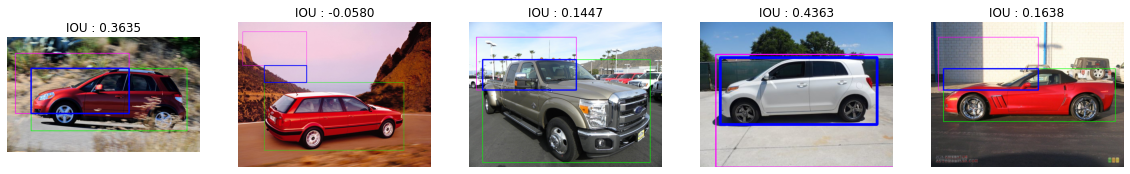

In [47]:
# lets display a few images with the bounding boxes, intersection & IOU
indices = np.random.choice(range(len(images)),5)
#indices = np.array([4066, 3122, 6133, 2252, 7679])
plt.figure(figsize=(20,10))
tfi = tf.keras.preprocessing.image
for i,index in enumerate(indices):
    plt.subplot(1,5,i+1)
    img = tfi.load_img(images[index][0]) # read image
    max_dims = np.array(img.size)
    img = tfi.img_to_array(img)
    cv2.rectangle(img,tuple(trueYbox[index][:2]),tuple(trueYbox[index][2:]),(0,255,0),2); # embed true bBox
    cv2.rectangle(img,tuple(predYbox[index][:2]),tuple(predYbox[index][2:]),(255,0,255),2); # embed predicted bBox
    Ix1,Iy1,Ix2,Iy2 = inter(max_dims,trueYbox[index],predYbox[index]) # calculate intersection
    cv2.rectangle(img,(Ix1[0],Iy1[0]),(Ix2[0],Iy2[0]),(0,0,255),5); # highlight Union
    img = tfi.array_to_img(img)
    plt.axis('off')
    iou = IOU(max_dims,trueYbox[index],predYbox[index]) # calculate IOU metric
    plt.title("IOU : %.4f"%iou)
    plt.imshow(img);
plt.show()

In [48]:
# compute IOU for the median model
print("mean of MEDIAN box IOU  : %.6f"%IOU(dims,trueYbox,predYbox).mean())
print("loss of MEDIAN box      : %.6f"%metrics.mean_squared_error(trueYbox,predYbox))

mean of MEDIAN box IOU  : 0.369283
loss of MEDIAN box      : 67704.714821


In [49]:
# let us create a log of the metrics & loss values
lCols = ['modelName','loss','names_loss','boxes_loss','names_accuracy','names_precision','names_recall',
         'boxes_IoU','val_loss','val_names_loss','val_boxes_loss','val_names_accuracy','val_names_precision',
         'val_names_recall','val_boxes_IoU']
resLog = pd.DataFrame(columns=lCols)

In [50]:
# Log for model1
mLog = np.array(["Modal_&_Median"],dtype=object)
# log of metrics & losses for training dataset
names_loss = tf.add_n(tf.keras.losses.categorical_crossentropy(trueY,predY))
boxes_loss = metrics.mean_squared_error(trueYbox,predYbox)
loss_sum = names_loss+boxes_loss

mLog = np.append(mLog,loss_sum)
mLog = np.append(mLog,names_loss)
mLog = np.append(mLog,boxes_loss)
mLog = np.append(mLog,metrics.accuracy_score(trueY,predY))
mLog = np.append(mLog,metrics.precision_score(trueY,predY,average='macro',zero_division=0))
mLog = np.append(mLog,metrics.recall_score(trueY,predY,average='macro'))
mLog = np.append(mLog,IOU(dims,trueYbox,predYbox).mean())

# metrics & losses for testing dataset
testY = enc.transform(testDF.folderName.values.reshape(-1, 1))
predTestY = enc.transform(np.array(['GMC Savana Van 2012']*len(testDF)).reshape(-1, 1))/1.0 # predict as the mode
testYbox = testDF[["x1","y1","x2","y2"]].values
predTestYbox = np.empty_like(testYbox)
predTestYbox[:] = trainDF[["x1","y1","x2","y2"]].median().values
testDims = testDF[["height","width"]].astype(int).values

# log of metrics & losses for testing dataset
names_loss = tf.add_n(tf.keras.losses.categorical_crossentropy(testY,predTestY))
boxes_loss = metrics.mean_squared_error(testYbox,predTestYbox)
loss_sum = names_loss+boxes_loss

mLog = np.append(mLog,loss_sum)
mLog = np.append(mLog,names_loss)
mLog = np.append(mLog,boxes_loss)
mLog = np.append(mLog,metrics.accuracy_score(testY,predTestY))
mLog = np.append(mLog,metrics.precision_score(testY,predTestY,average='macro',zero_division=0))
mLog = np.append(mLog,metrics.recall_score(testY,predTestY,average='macro'))
mLog = np.append(mLog,IOU(testDims,testYbox,predTestYbox).mean())

In [51]:
# append to results log
resLog = resLog.append(pd.DataFrame(mLog.reshape(1,-1),columns=lCols))
resLog

,modelName,loss,names_loss,boxes_loss,names_accuracy,names_precision,names_recall,boxes_IoU,val_loss,val_names_loss,val_boxes_loss,val_names_accuracy,val_names_precision,val_names_recall,val_boxes_IoU
0,Modal_&_Median,197874.455305,130169.740484,67704.714821,0.00835,0.000043,0.005102,0.369283,196759.050143,128509.576632,68249.473511,0.008457,0.000043,0.005102,0.261405


### model trial 2 - random prediction

In [52]:
# Random consistency seed
np.random.seed(100)
tf.random.set_seed(100)
# class predictions
trueY = enc.fit_transform(trainDF.folderName.values.reshape(-1, 1))
predY = enc.transform(np.random.choice(trainDF.folderName.values,trainDF.shape[0],replace=False).reshape(-1, 1))/1.0
# box predicitons
trueYbox = trainDF[["x1","y1","x2","y2"]].values
# 2 random x values within the image
x12 = np.array(list(map(np.random.randint,np.zeros(len(trainDF.width)),trainDF.width.values,[2]*len(trainDF.width))))
# 2 random x values within the image
y12 = np.array(list(map(np.random.randint,np.zeros(len(trainDF.height)),trainDF.height.values,[2]*len(trainDF.height))))
# assemble the box coordinates
predYbox = np.array((x12[:,0],y12[:,0],x12[:,1],y12[:,1])).transpose()
# max dims
dims = trainDF[["width","height"]].astype(int).values

# Log for model1
mLog = np.array(["Random"],dtype=object)
# log of metrics & losses for training dataset
names_loss = tf.add_n(tf.keras.losses.categorical_crossentropy(trueY,predY))
boxes_loss = metrics.mean_squared_error(trueYbox,predYbox)
loss_sum = names_loss+boxes_loss

mLog = np.append(mLog,loss_sum)
mLog = np.append(mLog,names_loss)
mLog = np.append(mLog,boxes_loss)
mLog = np.append(mLog,metrics.accuracy_score(trueY,predY))
mLog = np.append(mLog,metrics.precision_score(trueY,predY,average='macro',zero_division=0))
mLog = np.append(mLog,metrics.recall_score(trueY,predY,average='macro'))
mLog = np.append(mLog,IOU(dims,trueYbox,predYbox).mean())

# metrics & losses for testing dataset
# class predictions
testY = enc.transform(testDF.folderName.values.reshape(-1, 1))
predTestY = enc.transform(np.random.choice(testDF.folderName.values,testDF.shape[0],replace=False).reshape(-1, 1))/1.0
# box predicitons
testYbox = testDF[["x1","y1","x2","y2"]].values
# 2 random x values within the image
x12 = np.array(list(map(np.random.randint,np.zeros(len(testDF.width)),testDF.width.values,[2]*len(testDF.width))))
# 2 random x values within the image
y12 = np.array(list(map(np.random.randint,np.zeros(len(testDF.height)),testDF.height.values,[2]*len(testDF.height))))
# assemble the box coordinates
predYbox = np.array((x12[:,0],y12[:,0],x12[:,1],y12[:,1])).transpose()
# max dims
testDims = testDF[["width","height"]].astype(int).values

# log of metrics & losses for testing dataset
names_loss = tf.add_n(tf.keras.losses.categorical_crossentropy(testY,predTestY))
boxes_loss = metrics.mean_squared_error(testYbox,predTestYbox)
loss_sum = names_loss+boxes_loss

mLog = np.append(mLog,loss_sum)
mLog = np.append(mLog,names_loss)
mLog = np.append(mLog,boxes_loss)
mLog = np.append(mLog,metrics.accuracy_score(testY,predTestY))
mLog = np.append(mLog,metrics.precision_score(testY,predTestY,average='macro',zero_division=0))
mLog = np.append(mLog,metrics.recall_score(testY,predTestY,average='macro'))
mLog = np.append(mLog,IOU(testDims,testYbox,predTestYbox).mean())

# append to results log
resLog = resLog.append(pd.DataFrame(mLog.reshape(1,-1),columns=lCols))
resLog

,modelName,loss,names_loss,boxes_loss,names_accuracy,names_precision,names_recall,boxes_IoU,val_loss,val_names_loss,val_boxes_loss,val_names_accuracy,val_names_precision,val_names_recall,val_boxes_IoU
0,Modal_&_Median,197874.455305,130169.740484,67704.714821,0.00835,0.000043,0.005102,0.369283,196759.050143,128509.576632,68249.473511,0.008457,0.000043,0.005102,0.261405
0,Random,251891.100331,130443.748108,121447.352222,0.006262,0.006204,0.006204,0.000323,197178.120627,128928.647116,68249.473511,0.005223,0.005326,0.005326,0.37186


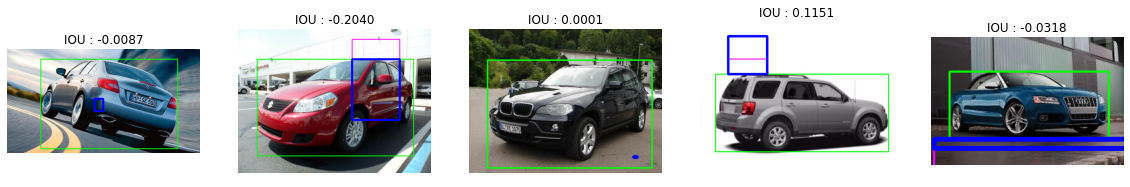

In [53]:
# lets display a few images with the bounding boxes, intersection & IOU
indices = np.random.choice(range(len(images)),5)
#indices = np.array([4066, 3122, 6133, 2252, 7679])
plt.figure(figsize=(20,10))
tfi = tf.keras.preprocessing.image
for i,index in enumerate(indices):
    plt.subplot(1,5,i+1)
    img = tfi.load_img(images[index][0]) # read image
    max_dims = np.array(img.size)
    img = tfi.img_to_array(img)
    cv2.rectangle(img,tuple(trueYbox[index][:2]),tuple(trueYbox[index][2:]),(0,255,0),2); # embed true bBox
    cv2.rectangle(img,tuple(predYbox[index][:2]),tuple(predYbox[index][2:]),(255,0,255),2); # embed predicted bBox
    Ix1,Iy1,Ix2,Iy2 = inter(max_dims,trueYbox[index],predYbox[index]) # calculate intersection
    cv2.rectangle(img,(Ix1[0],Iy1[0]),(Ix2[0],Iy2[0]),(0,0,255),5); # highlight Union
    img = tfi.array_to_img(img)
    plt.axis('off')
    iou = IOU(max_dims,trueYbox[index],predYbox[index]) # calculate IOU metric
    plt.title("IOU : %.4f"%iou)
    plt.imshow(img);
plt.show()

### Preparations for Neural Network Models

In [20]:
class newGen(tf.keras.utils.Sequence):
    """Image Data Generator for multi-output models    
    --------------------------------------------------------------------------------------------------
    a typical tensorflow ImageDataGenerator does not suit the purpose as it cannot map multiple output
    also the same cannot perform custom augmentations that include transformations for bounding boxes
    """
    def __init__(self,train,test,imagePath,className,bBox,
                 target_size=(200,200),batch_size=32,validation_split=None,seed=100):
        
        super(newGen,self).__init__()
        
        self.target_size = target_size
        self.batch_size = batch_size
        self.vSplit = validation_split
        self.seed = seed        
        self.train = train.copy()
        self.test = test.copy()
        
        # generator setup completion flag
        self.GENERATE = False
        
        if self.vSplit == None:
            self.noSplit(imagePath,className,bBox)
        else:
            self.split(imagePath,className,bBox)
            
        # class encoder
        self.enc = LabelBinarizer().fit(self.trClassName.values)
        
        # epoch counter
        self.epoch = None        
    
    def noSplit(self,imagePath,className,bBox):
        # shuffle training set alone
        self.train = self.train.sample(frac=1,random_state=self.seed).reset_index(drop=True)
        # X inputs
        self.trImagePath,self.ttImagePath = self.train[imagePath],self.test[imagePath]
        # Y class outputs
        self.trClassName, self.ttClassName= self.train[className],self.test[className]
        # Y bBox outputs
        self.trbBox,self.ttbBox = self.train[bBox],self.test[bBox]
        
    def split(self,imagePath,className,bBox):        
        # random index split
        np.random.seed(self.seed)
        index = np.random.choice(self.train.index,size=self.train.shape[0],replace=False)
        trIndex = index[:-int(self.train.shape[0]*self.vSplit)]
        vIndex = index[-int(self.train.shape[0]*self.vSplit):]
        self.trdf = self.train.loc[trIndex].reset_index(drop=True,inplace=False)
        self.vdf = self.train.loc[vIndex].reset_index(drop=True,inplace=False)
        
        # X inputs
        self.trImagePath,self.vImagePath,self.ttImagePath = self.trdf[imagePath],self.vdf[imagePath],self.test[imagePath]
        # Y class outputs
        self.trClassName,self.vClassName,self.ttClassName = self.trdf[className],self.vdf[className],self.test[className]
        # Y bBox outputs
        self.trbBox,self.vbBox,self.ttbBox = self.trdf[bBox],self.vdf[bBox],self.test[bBox]
        
    def subset(self,subset_name):
        objCopy = deepcopy(self) #  create a copy of the generator instance
        # set output data
        if subset_name == "training":
            objCopy.imPath,objCopy.cName,objCopy.bBox = objCopy.trImagePath,objCopy.trClassName,objCopy.trbBox
        elif subset_name == "validation":
            objCopy.imPath,objCopy.cName,objCopy.bBox = objCopy.vImagePath,objCopy.vClassName,objCopy.vbBox
        elif subset_name == 'testing':
            objCopy.imPath,objCopy.cName,objCopy.bBox = objCopy.ttImagePath,objCopy.ttClassName,objCopy.ttbBox
        # update length data
        objCopy.nSteps = (objCopy.bBox.shape[0] // objCopy.batch_size) + 1
        # set the generator as ready
        objCopy.lastIndex = 0
        objCopy.GENERATE = True
        # print
        print("registered %d images serving %d steps for %s"%(objCopy.bBox.shape[0],objCopy.nSteps,subset_name))
        return objCopy # return the modified generator
        
    def on_epoch_end(self):
        if self.epoch == None:
            self.epoch = 0
        np.random.seed(self.seed+self.epoch)
        index = np.random.choice(self.bBox.index,self.bBox.shape[0],replace=False)
        self.imPath = self.imPath.loc[index].reset_index(drop=True)
        self.cName = self.cName.loc[index].reset_index(drop=True)
        self.bBox.loc[index].reset_index(drop=True,inplace=True)
        self.epoch+=1
        
    def resize(self,images,boxes):
        # box transform
        iSize = np.array([np.array(i.shape[:2][::-1]) for i in images])
        iSize = np.append(iSize,iSize,axis=1)
        # we can also create a output target size matrix, multipy to obtain bounding boxes in new size
        # but let us not do it, so that the bounding box coordinates remain normalizes to unit dimensions
        # equivalent steps can be uncommented below if needed
        # oSize = np.array(self.target_size*self.batch_size).reshape(-1,2)
        # oSize = np.append(oSize,oSize,axis=1)
        # boxes = np.multiply(boxes,np.divide(oSize,iSize)).astype(int)
        boxes = np.divide(boxes,iSize)
        # image transform
        images = np.array([cv2.resize(image,self.target_size) for image in images])
        return images,boxes
        
    def fetchBatch(self,index):
        tfi = tf.keras.preprocessing.image
        images = np.asarray([tfi.img_to_array(tfi.load_img(image)) for image in self.imPath.loc[index]],dtype=object)
        boxes = self.bBox.loc[index].values
        names = self.enc.transform(self.cName.loc[index].values).astype(float)
        # resize
        images,boxes = self.resize(images,boxes)
        # normalise
        images = images/255.0
        return images,tuple((names,boxes))
        
    def __getitem__(self,step):
        index = self.bBox.index[step*self.batch_size:(step+1)*self.batch_size]
        X,Y = self.fetchBatch(index)
        self.lastIndex = (step+1)*self.batch_size if (step+1)*self.batch_size<self.bBox.shape[0] else 0
        return X,Y
    
    def next(self):
        index = self.bBox.index[self.lastIndex:self.lastIndex+self.batch_size]
        X,Y = self.fetchBatch(index)
        self.lastIndex = self.lastIndex+self.batch_size if self.lastIndex+self.batch_size<self.bBox.shape[0] else 0
        return X,Y
        
    def __len__(self):
        return self.nSteps

In [21]:
# compute Intersection-over-Union metrics
def IOU(y_true,y_pred):
    # intersection coordinates (x1,y1)
    x1 = tf.maximum(y_true[:,0],y_pred[:,0])
    y1 = tf.maximum(y_true[:,1],y_pred[:,1])
    # intersection coordinates (x2,y2)
    x2 = tf.minimum(y_true[:,2],y_pred[:,2])
    y2 = tf.minimum(y_true[:,3],y_pred[:,3])    
    # compute areas
    inter_area = (x2 - x1) * (y2 - y1)
    union_area = (y_true[:,2] - y_true[:,0]) * (y_true[:,3] - y_true[:,1]) # true bBox
    union_area += (y_pred[:,2] - y_pred[:,0]) * (y_pred[:,3] - y_pred[:,1]) # predicted bBox
    union_area -= inter_area # intersection area
    return (inter_area / (union_area + K.epsilon()))

def IoU(y_true, y_pred):
    return tf.py_function(IOU,[y_true, y_pred],tf.float32)

In [22]:
logdir = "logs"

In [23]:
%load_ext tensorboard
%tensorboard --logdir logs

In [24]:
def pipe(modelFunc,modelName,generator,
         modelParams={},generatorParams={},fitParams={},gridPoint={},evalParams={}):
        
    # generator implementation
    gens = generator(trainDF,testDF,"ImagePath","folderName",["x1","y1","x2","y2"],
                     validation_split=0.1,seed=100,**generatorParams)
    trainset = gens.subset('training')
    validationset = gens.subset('validation')
    testset = gens.subset('testing')
    
    # batch output shape for reference
    batch_size = generatorParams.get('batch_size')
    target_size = generatorParams.get('target_size')
    input_size = tuple((batch_size,target_size[0],target_size[1],3))
    modelParams.update(dict(input_size=input_size))
    
    # model implementation
    model = modelFunc(**modelParams)
    
    # optimizers
    optim = optimizers.Adagrad(learning_rate=gridPoint.get('learning_rate'))
    
    losses = {'names':'categorical_crossentropy',
              'boxes':'mse'}
    
    # metrics
    metrics = {'names':[tf.keras.metrics.Accuracy(name='accuracy'),
                        tf.keras.metrics.Precision(name='precision'),
                        tf.keras.metrics.Recall(name='recall')],
               'boxes':IoU}
    
    # compile model
    model.compile(optimizer=optim,loss=losses,metrics=metrics)
    
    # create tensorboard logs & callbacks
    logd = os.path.join(logdir, modelName)
    tensorboard_cb = tf.keras.callbacks.TensorBoard(logd, histogram_freq=1, embeddings_freq=1)
    
    # collect callbacks
    cbs = [tensorboard_cb]
    
    # update fitParams
    fitParams.update(dict(callbacks=cbs))
    
    # model fitting
    with tf.device(tf.test.gpu_device_name()):
        logger = model.fit(trainset,validation_data=validationset,**fitParams)
        
    # results Logging
    lCols = ["modelName"]+list(logger.history.keys())
    mLog = np.array([modelName],dtype=object)
    
    # evaluate on training set
    print("EVALUATION")
    trainingMetrics = model.evaluate(trainset,**evalParams)
    mLog = np.append(mLog,trainingMetrics)
    
    # evaluate on testing set
    testingMetrics = model.evaluate(testset,**evalParams)
    mLog = np.append(mLog,testingMetrics)
    
    # append to results log
    global resLog
    resLog = resLog.append(pd.DataFrame(mLog.reshape(1,-1),columns=lCols))
    
    # sample images with predictions
    evalset = trainset.next()
    predictions = model.predict(evalset[0])
    # names
    predNames=(predictions[0]>0.5)*1
    predNames=gens.enc.inverse_transform(predNames)
    # bBox IOU
    iouValues = IOU(evalset[1][1],predictions[1])
    # reference target size
    oSize = np.array(gens.target_size).reshape(-1,2)
    oSize = np.append(oSize,oSize,axis=1)
    
    # lets display a few images with the bounding boxes, intersection & IOU
    indices = np.random.choice(range(len(evalset[0])),5)
    plt.figure(figsize=(20,10))
    tfi = tf.keras.preprocessing.image
    for i,index in enumerate(indices):
        plt.subplot(1,5,i+1)
        img = evalset[0][index]*255 # read image

        #box coords
        trueYbox = evalset[1][1][index]
        trueYbox = np.multiply(trueYbox,oSize).astype(int).reshape(4)
        predYbox = predictions[1][index]
        predYbox = np.multiply(predYbox,oSize).astype(int).reshape(4)
        # intersection coordinates (x1,y1)
        x1 = np.maximum(trueYbox[0],predYbox[0])
        y1 = np.maximum(trueYbox[1],predYbox[1])
        # intersection coordinates (x2,y2)
        x2 = np.minimum(trueYbox[2],predYbox[2])
        y2 = np.minimum(trueYbox[3],predYbox[3])

        # add bounding boxes
        cv2.rectangle(img,tuple(trueYbox[:2]),tuple(trueYbox[2:]),(0,255,0),2); # embed true bBox
        cv2.rectangle(img,tuple(predYbox[:2]),tuple(predYbox[2:]),(255,0,255),2); # embed predicted bBox
        cv2.rectangle(img,(x1,y1),(x2,y2),(0,0,255),5); # highlight Union
        img = tfi.array_to_img(img)
        #plt.axis('off')
        iou = iouValues[index]
        plt.xlabel("IOU : %.4f"%iou)
        plt.title(predNames[index])
        plt.imshow(img);
    plt.show()

    return model,resLog,lCols

model trial 3 - Shallow Neural Network

trial network for pipeline setup

### model trial 3 - MobileNet base model

In [25]:
def MobileNetModel(input_size,alpha=1):
    #layers
    mobilenet = MobileNet(input_shape=input_size[1:],include_top=False,alpha=alpha,weights='imagenet')
    pool = GlobalMaxPool2D()(mobilenet.output)
    cls = Dense(196,activation='sigmoid',name="names")(pool)
    box = Dense(4,activation='relu',name="boxes")(pool)    
    # model assembly
    model = Model(inputs=mobilenet.inputs,outputs=[cls,box])
    for l in model.layers[:-3]:
        l.trainable = False
    return model

In [26]:
# generator parameters
gMNParams = dict(target_size=(128,128),batch_size=32)
# model creation parameters
mMNParams = dict(alpha=1)
# model fitting parameters
fMNParams = dict(epochs=10,verbose=1)
# other hyper parameters
gridMNPoint = dict(learning_rate=1e-4)

registered 7330 images serving 230 steps for training
registered 814 images serving 26 steps for validation
registered 8041 images serving 252 steps for testing


2022-07-10 20:47:08.017403: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-10 20:47:08.017685: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-10 20:47:08.017850: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-10 20:47:08.018046: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-10 20:47:08.018206: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

Epoch 1/10


2022-07-10 20:47:10.932380: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8400
2022-07-10 20:47:11.294167: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


230/230 [==============================] - 124s 525ms/step - loss: 12.0797 - names_loss: 11.4277 - boxes_loss: 0.6520 - names_accuracy: 6.9605e-07 - names_precision: 0.0051 - names_recall: 0.5816 - boxes_IoU: -0.0871 - val_loss: 10.9411 - val_names_loss: 10.4314 - val_boxes_loss: 0.5097 - val_names_accuracy: 0.0000e+00 - val_names_precision: 0.0052 - val_names_recall: 0.6229 - val_boxes_IoU: 0.0801
Epoch 2/10
230/230 [==============================] - 65s 283ms/step - loss: 11.5492 - names_loss: 9.9736 - boxes_loss: 1.5756 - names_accuracy: 0.0000e+00 - names_precision: 0.0051 - names_recall: 0.6244 - boxes_IoU: -7.9390e-04 - val_loss: 11.5239 - val_names_loss: 9.6914 - val_boxes_loss: 1.8324 - val_names_accuracy: 0.0000e+00 - val_names_precision: 0.0052 - val_names_recall: 0.6437 - val_boxes_IoU: -0.0950
Epoch 3/10
230/230 [==============================] - 64s 279ms/step - loss: 10.9937 - names_loss: 9.4307 - boxes_loss: 1.5629 - names_accuracy: 0.0000e+00 - names_precision: 0.0051 -

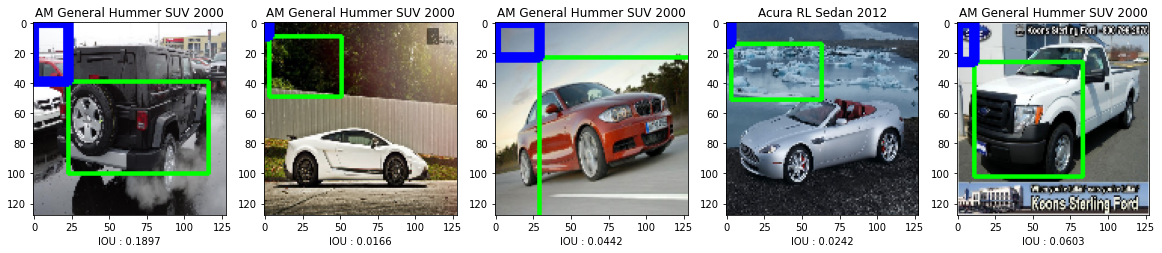

In [27]:
mobileNet,resLog,lCols = pipe(MobileNetModel,"mobilenet",newGen,generatorParams=gMNParams,fitParams=fMNParams,gridPoint=gridMNPoint)

In [28]:
resLog

,modelName,loss,names_loss,boxes_loss,names_accuracy,names_precision,names_recall,boxes_IoU,val_loss,val_names_loss,val_boxes_loss,val_names_accuracy,val_names_precision,val_names_recall,val_boxes_IoU
0,Modal_&_Median,197874.455305,130169.740484,67704.714821,0.00835,0.000043,0.005102,0.369283,196759.050143,128509.576632,68249.473511,0.008457,0.000043,0.005102,0.261405
0,Random,251891.100331,130443.748108,121447.352222,0.006262,0.006204,0.006204,0.000323,197178.120627,128928.647116,68249.473511,0.005223,0.005326,0.005326,0.37186
0,mobilenet,9.886306,8.306101,1.580204,0.0,0.005308,0.678854,-0.007015,8.757686,8.320807,0.436875,0.0,0.005389,0.688098,0.063102


### model trial 4 - VGG16 base model

In [29]:
def VGGModel(input_size):
    #layers
    vgg = VGG16(input_shape=input_size[1:],include_top=False,weights='imagenet')
    pool = GlobalMaxPool2D()(vgg.output)
    cls = Dense(196,activation='sigmoid',name="names")(pool)
    box = Dense(4,activation='relu',name="boxes")(pool)    
    # model assembly
    model = Model(inputs=vgg.inputs,outputs=[cls,box])
    for l in model.layers[:-3]:
        l.trainable = False
    return model

In [30]:
# generator parameters
gParams = dict(target_size=(128,128),batch_size=32)
# model creation parameters
mParams = dict()
# model fitting parameters
fParams = dict(epochs=10,verbose=1)
# other hyper parameters
gridPoint = dict(learning_rate=1e-4)

registered 7330 images serving 230 steps for training
registered 814 images serving 26 steps for validation
registered 8041 images serving 252 steps for testing


2022-07-10 21:01:52.873384: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-10 21:01:52.873695: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-10 21:01:52.873829: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-10 21:01:52.873982: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-10 21:01:52.874227: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

Epoch 1/10


2022-07-10 21:01:54.568158: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.04GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


230/230 [==============================] - 72s 302ms/step - loss: 6.4317 - names_loss: 5.8745 - boxes_loss: 0.5573 - names_accuracy: 0.0000e+00 - names_precision: 0.0051 - names_recall: 0.5366 - boxes_IoU: 0.3724 - val_loss: 6.2569 - val_names_loss: 5.8022 - val_boxes_loss: 0.4547 - val_names_accuracy: 0.0000e+00 - val_names_precision: 0.0053 - val_names_recall: 0.5676 - val_boxes_IoU: 1.5469
Epoch 2/10
230/230 [==============================] - 66s 287ms/step - loss: 7.1489 - names_loss: 5.7957 - boxes_loss: 1.3532 - names_accuracy: 0.0000e+00 - names_precision: 0.0051 - names_recall: 0.5476 - boxes_IoU: 0.3158 - val_loss: 7.3179 - val_names_loss: 5.7461 - val_boxes_loss: 1.5718 - val_names_accuracy: 0.0000e+00 - val_names_precision: 0.0053 - val_names_recall: 0.5749 - val_boxes_IoU: 0.2276
Epoch 3/10
230/230 [==============================] - 66s 288ms/step - loss: 7.0593 - names_loss: 5.7456 - boxes_loss: 1.3137 - names_accuracy: 0.0000e+00 - names_precision: 0.0051 - names_recall: 

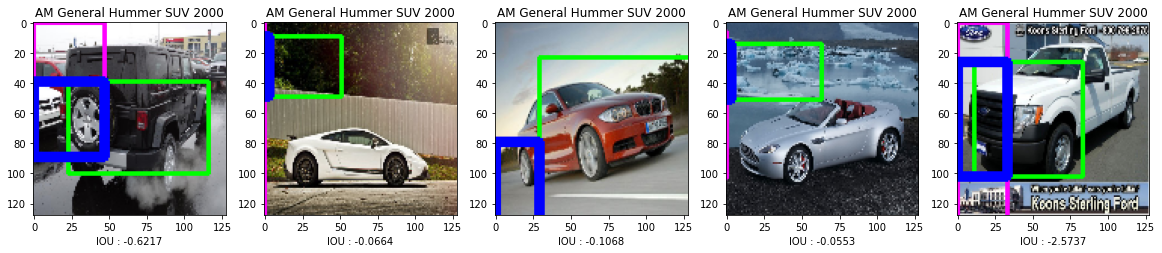

In [31]:
VGG,resLog,lCols = pipe(VGGModel,"VGG16",newGen,generatorParams=gParams,fitParams=fParams,gridPoint=gridPoint)

In [32]:
resLog

,modelName,loss,names_loss,boxes_loss,names_accuracy,names_precision,names_recall,boxes_IoU,val_loss,val_names_loss,val_boxes_loss,val_names_accuracy,val_names_precision,val_names_recall,val_boxes_IoU
0,Modal_&_Median,197874.455305,130169.740484,67704.714821,0.00835,0.000043,0.005102,0.369283,196759.050143,128509.576632,68249.473511,0.008457,0.000043,0.005102,0.261405
0,Random,251891.100331,130443.748108,121447.352222,0.006262,0.006204,0.006204,0.000323,197178.120627,128928.647116,68249.473511,0.005223,0.005326,0.005326,0.37186
0,mobilenet,9.886306,8.306101,1.580204,0.0,0.005308,0.678854,-0.007015,8.757686,8.320807,0.436875,0.0,0.005389,0.688098,0.063102
0,VGG16,6.86995,5.574183,1.295765,0.0,0.005114,0.581446,-0.160455,5.944128,5.585669,0.358463,0.0,0.00511,0.580774,-0.550717


### Inferences
**Modal&Median**
* the central tendencies of the input dataset is refered as the generic model output
* the results has extremely huge losses, yet the bounding box IOU has achived a decent 0.26 for an unlearned model
* class prediction accuracies are less than 1%, and its understandable for the 196 possibilities
**Random model**
* ignoring any information about the input distributions, random values from the target space was considered as the prediction
* huge loses witnessed again, and the random bounding box seems to cover IOU of 0.37 in testing dataset
* class prediction accuracies are less than 1% as expected for these unlearned models
**these gives us a significant target for the trained models**

**MobileNet**
* transfer learning of MobileNet was implemented, with its layers frozen
* the losses are far less (possibly cause by scaling of input data between 0 & 1), hence not directly comparable with the previous two models
* the class predicition accuracy are shut to ZERO, and needs to explored before hyperparameter tuning
* the class recall score has show valuable growth in performance (0.688 in testing data)
* the bounding box IOU has secured only 0.06 in testing data, which inferes that there is not much learning. the same is substantiated with the negative IOU in training data

**VGG16**
* transfer learning of VGG16 was implemented, with its layers frozen
* the losses are notionaly lesser in comparison with MobileNet
* the bounding box predictions are also infering that not much of a learning has happened